In [1]:
import json
import os
import csv
import numpy as np
import random
import re
from typing import Optional
from tqdm import tqdm
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from PIL import Image
import torch
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
from torch import optim, nn
from transformers import ViltProcessor, ViltForQuestionAnswering
import pandas as pd
from tqdm import tqdm 

/nfs/home/scg1143/.conda/envs/project_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_json_dir = "/nfs/home/scg1143/MLDS/Quarter3/DeepLearning/Project/VQA-ObjectDetection/vizviz/vqa/train_df_RN50.json"
val_json_dir = "/nfs/home/scg1143/MLDS/Quarter3/DeepLearning/Project/VQA-ObjectDetection/vizviz/vqa/val_df_RN50.json"
classmapping_dir = "/nfs/home/scg1143/MLDS/Quarter3/DeepLearning/Project/VQA-ObjectDetection/vizviz/vqa/class_mapping.csv"

batch_size = 32
num_epoch = 25
learning_rate = 5e-4
es_patience = 8
lr_patience = 3
model_save_path = "ckpt_vilt.pth"

In [3]:
with open(classmapping_dir, "r") as f:
    next(f)  # Skip the header
    reader = csv.reader(f, skipinitialspace=True)
    class_mapping = dict(reader)
    label2id = {k: int(v) for k, v in class_mapping.items()}
    id2label = {v: k for k, v in label2id.items()}

In [4]:
def get_score(count: int) -> float:
    return min(1.0, count / 3)

def add_label_score(data):
    label_list = []
    score_list = []
    for idx, annotation in data.iterrows():
        answers_dict = annotation["answers"]
        answer_count = {}
        for answers in answers_dict:
            answer = answers["answer"]
            answer_count[answer] = answer_count.get(answer, 0) + 1

        labels = []
        scores = []
        for answer_word in answer_count:
            if answer_word in list(label2id.keys()):
                labels.append(label2id[answer_word])
                scores.append(get_score(answer_count[answer_word]))

        label_list.append(labels)
        score_list.append(scores)
    data['labels'] = label_list
    data['scores'] = score_list
    return data

In [5]:
def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateX(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[0]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert -0.45 <= v <= 0.45
    if random.random() > 0.5:
        v = -v
    v = v * img.size[1]
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Flip(img, _):  # not from the paper
    return PIL.ImageOps.mirror(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(np.int32)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def SamplePairing(imgs):  # [0, 0.4]
    def f(img1, v):
        i = np.random.choice(len(imgs))
        img2 = PIL.Image.fromarray(imgs[i])
        return PIL.Image.blend(img1, img2, v)

    return f


def Identity(img, v):
    return img


def augment_list():  # 16 oeprations and their ranges
    # https://github.com/google-research/uda/blob/master/image/randaugment/policies.py#L57
    # https://github.com/tensorflow/tpu/blob/8462d083dd89489a79e3200bcc8d4063bf362186/models/official/efficientnet/autoaugment.py#L505
    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0.0, 0.3),
        (ShearY, 0.0, 0.3),
        (TranslateXabs, 0.0, 100),
        (TranslateYabs, 0.0, 100),
    ]

    return l


class RandAugment:
    def __init__(self, n, m):
        self.n = n
        self.m = m  # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img


In [6]:
class VQADataset(torch.utils.data.Dataset):
    """VQA (v2) dataset."""

    def __init__(self, data, processor):
        print(f"Actual Data Size : {data.shape[0]}")
        self.data = data[data.answerable == 1]
        print(f"Filtered Data Size : {self.data.shape[0]}")
        self.image_paths = self.data.image_path.tolist()
        self.labels = self.data.labels.tolist()
        self.scores = self.data.scores.tolist()
        self.questions = self.data.question.tolist()
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # get image + text]
        image = Image.open(self.image_paths[idx])
        augmenter = RandAugment(n=2, m=9)
        image = augmenter(image)
        text = self.questions[idx]

        encoding = self.processor(image, text, padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        # add labels
        labels = self.labels[idx]
        scores = self.scores[idx]
        # # based on: https://github.com/dandelin/ViLT/blob/762fd3975c180db6fc88f577cf39549983fa373a/vilt/modules/objectives.py#L301
        targets = torch.zeros(len(label2id))
        for label, score in zip(labels, scores):
              targets[label] = score
        encoding["labels"] = targets
        return encoding

In [7]:
processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")

In [8]:
train_data = pd.read_json(train_json_dir)
val_data = pd.read_json(val_json_dir)

train_data = add_label_score(train_data)
val_data = add_label_score(val_data)

In [9]:
train_dataset = VQADataset(train_data, processor)
val_dataset = VQADataset(val_data, processor)

Actual Data Size : 20523
Filtered Data Size : 12935
Actual Data Size : 4319
Filtered Data Size : 2448


In [10]:
device=torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm",
                                                 id2label=id2label,
                                                 label2id=label2id)

model.to(device)

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViltForQuestionAnswering(
  (vilt): ViltModel(
    (embeddings): ViltEmbeddings(
      (text_embeddings): TextEmbeddings(
        (word_embeddings): Embedding(30522, 768)
        (position_embeddings): Embedding(40, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (patch_embeddings): ViltPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
      )
      (token_type_embeddings): Embedding(2, 768)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViltEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViltLayer(
          (attention): ViltAttention(
            (attention): ViltSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=76

In [11]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    token_type_ids = [item['token_type_ids'] for item in batch]
    labels = [item['labels'] for item in batch]

    # create padded pixel values and corresponding pixel mask
    encoding = processor.image_processor.pad(pixel_values, return_tensors="pt")

    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['token_type_ids'] = torch.stack(token_type_ids)
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = torch.stack(labels)

    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=batch_size, 
                              shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1, 
                            shuffle=False, num_workers=2, pin_memory=True)


In [12]:
# Early Stopping
# Stop training if validation loss does not improve
class EarlyStopping:

    def __init__(self, patience, model_save_path, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.model_save_path = model_save_path
        self.counter = 0
        self.min_validation_loss = np.inf
        self.best_epoch = 0
        self.early_stop = False


    def __call__(self, epoch, model, validation_loss):
        delta_loss = self.min_validation_loss - validation_loss
        # Check if val loss is smaller than min loss
        if delta_loss > self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
            # Save best model
            self.best_epoch = epoch
            torch.save(model.state_dict(), self.model_save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print(f"Early Stopping.")
                print(f"Save best model at epoch {self.best_epoch}")
                self.early_stop = True

In [13]:
# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Reduce learning rate when validation loss stops improving
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=lr_patience, verbose=True)

/nfs/home/scg1143/.conda/envs/project_env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [14]:
def train_model(data_loader, model, optimizer, device):
    num_batches = len(data_loader)
    # Define loss
    total_loss = 0
    
    model.train()
    for batch in tqdm(data_loader):
        # get the inputs;
        inputs = {k:v.to(device) for k,v in batch.items()}
        # forward pass
        outputs = model(**inputs)
        loss = outputs.loss
        # backward and optimize
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # Loss over batches
    train_loss = total_loss / num_batches

    return train_loss


def val_model(data_loader, model, device):
    num_batches = len(data_loader)
    # Define loss and accuracy
    total_loss = 0
    total_acc = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(data_loader):
            inputs = {k:v.to(device) for k,v in batch.items()}
            outputs = model(**inputs)

            # Calculate loss
            loss = outputs.loss
            total_loss += loss.item()

            # Get top predict for each question
            preds = outputs.logits.argmax(-1)
            # Get ground truth answers for each questiojn
            scores, labels = batch["labels"].to(device).topk(10, -1)
            # Calculate accuracy
            total_acc += scores[preds==labels].sum() / len(preds)
            
    # Accuracy over batches
    val_acc = total_acc / num_batches
    # Loss over batches
    val_loss = total_loss / num_batches

    return val_acc, val_loss

In [15]:
# Log metrics for plotting
all_losses = []

# Initialize Early Stopping object
early_stopper = EarlyStopping(patience=es_patience, model_save_path=model_save_path)
for epoch in range(num_epoch):
    print(f"Epoch [{epoch}/{num_epoch-1}]")
    train_loss = train_model(train_dataloader, model, optimizer, device)
    val_acc, val_loss = val_model(val_dataloader, model, device)
    
    all_losses.append([train_loss, val_loss])

    # Display
    print(f"Train loss: {train_loss:.5f} - Val loss: {val_loss:.5f}")
    print(f"Val accuracy: {val_acc:.5f}\n")
    
    # EarlyStopping
    early_stopper(epoch, model, val_loss)
    if early_stopper.early_stop:
        break
    # Adjust learning rate
    lr_scheduler.step(val_loss)

Epoch [0/24]


100%|██████████| 2448/2448 [02:13<00:00, 18.32it/s]


Train loss: 62.47511 - Val loss: 11.65299
Val accuracy: 0.18995

Epoch [1/24]


100%|██████████| 2448/2448 [02:26<00:00, 16.70it/s]


Train loss: 11.74776 - Val loss: 11.71814
Val accuracy: 0.18995

Epoch [2/24]


100%|██████████| 2448/2448 [02:10<00:00, 18.82it/s]


Train loss: 11.62776 - Val loss: 11.27128
Val accuracy: 0.21324

Epoch [3/24]


100%|██████████| 2448/2448 [02:15<00:00, 18.10it/s]


Train loss: 11.03151 - Val loss: 10.92726
Val accuracy: 0.22699

Epoch [4/24]


100%|██████████| 2448/2448 [02:11<00:00, 18.57it/s]


Train loss: 10.65250 - Val loss: 10.71354
Val accuracy: 0.22263

Epoch [5/24]


100%|██████████| 2448/2448 [02:04<00:00, 19.62it/s]


Train loss: 10.19787 - Val loss: 10.48232
Val accuracy: 0.21718

Epoch [6/24]


100%|██████████| 2448/2448 [01:59<00:00, 20.42it/s]


Train loss: 9.64035 - Val loss: 10.29078
Val accuracy: 0.25095

Epoch [7/24]


100%|██████████| 2448/2448 [02:43<00:00, 14.98it/s]


Train loss: 8.98780 - Val loss: 10.01609
Val accuracy: 0.25871

Epoch [8/24]


100%|██████████| 2448/2448 [02:10<00:00, 18.76it/s]


Train loss: 8.26321 - Val loss: 9.81302
Val accuracy: 0.27219

Epoch [9/24]


100%|██████████| 2448/2448 [02:14<00:00, 18.25it/s]


Train loss: 7.58526 - Val loss: 9.69595
Val accuracy: 0.27601

Epoch [10/24]


100%|██████████| 2448/2448 [02:15<00:00, 18.11it/s]


Train loss: 6.99012 - Val loss: 9.66893
Val accuracy: 0.28717

Epoch [11/24]


100%|██████████| 2448/2448 [02:08<00:00, 19.02it/s]


Train loss: 6.37678 - Val loss: 9.70813
Val accuracy: 0.27859

Epoch [12/24]


100%|██████████| 2448/2448 [02:09<00:00, 18.90it/s]


Train loss: 5.79724 - Val loss: 9.69182
Val accuracy: 0.27642

Epoch [13/24]


100%|██████████| 2448/2448 [01:56<00:00, 20.93it/s]


Train loss: 5.28408 - Val loss: 10.01578
Val accuracy: 0.28853

Epoch [14/24]


100%|██████████| 2448/2448 [01:56<00:00, 21.09it/s]


Train loss: 4.92074 - Val loss: 10.08037
Val accuracy: 0.29425

Epoch [15/24]


100%|██████████| 2448/2448 [01:57<00:00, 20.75it/s]


Train loss: 3.44816 - Val loss: 9.57836
Val accuracy: 0.33483

Epoch [16/24]


100%|██████████| 2448/2448 [01:58<00:00, 20.75it/s]


Train loss: 2.84032 - Val loss: 9.75700
Val accuracy: 0.32789

Epoch [17/24]


100%|██████████| 2448/2448 [02:05<00:00, 19.47it/s]


Train loss: 2.51070 - Val loss: 9.95017
Val accuracy: 0.33115

Epoch [18/24]


100%|██████████| 2448/2448 [01:58<00:00, 20.58it/s]


Train loss: 2.28034 - Val loss: 10.14151
Val accuracy: 0.33429

Epoch [19/24]


100%|██████████| 2448/2448 [01:59<00:00, 20.44it/s]


Train loss: 2.11191 - Val loss: 10.36986
Val accuracy: 0.32680

Epoch [20/24]


100%|██████████| 2448/2448 [01:58<00:00, 20.72it/s]


Train loss: 1.79632 - Val loss: 10.37869
Val accuracy: 0.34355

Epoch [21/24]


100%|██████████| 2448/2448 [01:58<00:00, 20.74it/s]


Train loss: 1.62921 - Val loss: 10.54330
Val accuracy: 0.34736

Epoch [22/24]


100%|██████████| 2448/2448 [01:58<00:00, 20.73it/s]


Train loss: 1.55231 - Val loss: 10.62941
Val accuracy: 0.34246

Epoch [23/24]


  0%|          | 0/404 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [16]:
from io import BytesIO
import matplotlib.pyplot as plt
import requests

Question: Is there a tiger
Predicted answer: yes
Question: Is this a dog?
Predicted answer: no
Question: What is the animal?
Predicted answer: dog
Question: What is the color of the cat
Predicted answer: brown


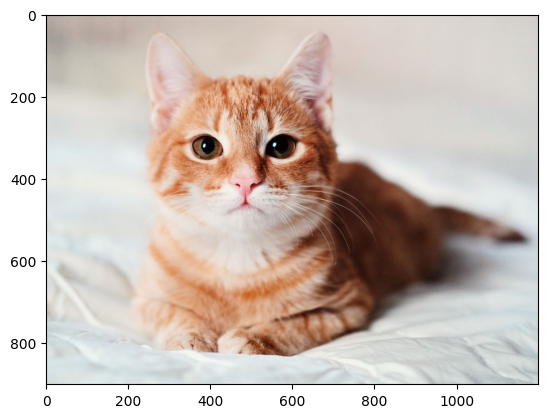

In [22]:
url2 = "https://hips.hearstapps.com/hmg-prod/images/beautiful-smooth-haired-red-cat-lies-on-the-sofa-royalty-free-image-1678488026.jpg?crop=0.88847xw:1xh;center,top&resize=1200:*"
img2 = Image.open(BytesIO(requests.get(url2).content)).convert('RGB')
plt.imshow(img2)

text = "Is there a tiger"
questions = ["Is there a tiger", "Is this a dog?", "What is the animal?", "What is the color of the cat"]

for question in questions:
    print(f"Question: {question}")
    encoding = processor(img2, question, return_tensors="pt")
    encoding.to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    print("Predicted answer:", model.config.id2label[idx])

Question: What is the color of the notebook?
Predicted answer: blue
Question: Is there a black pen
Predicted answer: yes
Question: What is this?
Predicted answer: stapler
Question: What color is the pen?
Predicted answer: blue
Question: Is there a car?
Predicted answer: no


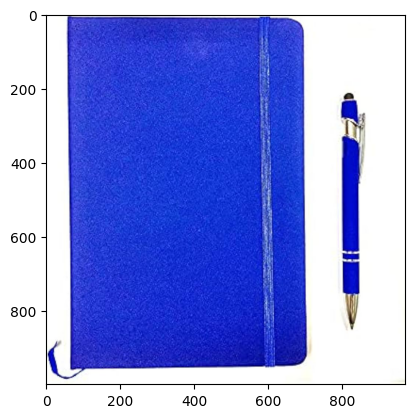

In [24]:
url = "https://m.media-amazon.com/images/I/41GqkUR423S._AC_UF1000,1000_QL80_.jpg"
img = Image.open(BytesIO(requests.get(url).content)).convert('RGB')
plt.imshow(img)
questions = ["What is the color of the notebook?",
            "Is there a black pen", 
            "What is this?",
            "What color is the pen?", 
            "Is there a car?"
            ]
for question in questions:
    print(f"Question: {question}")
    encoding = processor(img, question, return_tensors="pt")
    encoding.to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    print("Predicted answer:", model.config.id2label[idx])

Question: does he have a beard?
Predicted answer: yes
Question: Is this a bread in the hand?
Predicted answer: no
Question: Is the person Bald?
Predicted answer: no
Question: What is the gender of the person?
Predicted answer: unanswerable
Question: What is the person wearing?
Predicted answer: blue shorts
Question: What is the person holding in hands?
Predicted answer: unanswerable


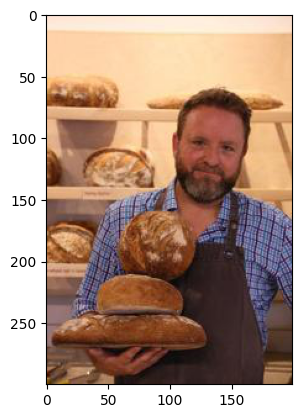

: 

In [36]:
url3 = "https://bloximages.chicago2.vip.townnews.com/stcatharinesstandard.ca/content/tncms/assets/v3/editorial/7/b4/7b49fe46-8d31-59f5-bb4a-d1b2541dc991/64f77512eb287.image.jpg?resize=200%2C300"
img = Image.open(BytesIO(requests.get(url3).content)).convert('RGB')
plt.imshow(img)
questions = ["does he have a beard?", 
            "Is this a bread in the hand?", 
            "Is the person Bald?",
             "What is the gender of the person?",
             "What is the person wearing?",
             "What is the person holding in hands?"
             ]

for question in questions:
    print(f"Question: {question}")
    encoding = processor(img, question, return_tensors="pt")
    encoding.to(device)
    outputs = model(**encoding)
    logits = outputs.logits
    idx = logits.argmax(-1).item()
    print("Predicted answer:", model.config.id2label[idx])
